In [ ]:
!pip3 install pandas
!pip3 install tensorflow-hub
!pip install tensorflow-text
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install scikit-learn

In [1]:
import pandas as pd # for loading and manipulating data
import numpy as np # for linear algebra
import os # to get list, path etc
import seaborn as sns # data visualization

import tensorflow as tf # for machine learning
import tensorflow_hub as hub # for using pretrained models
import tensorflow_text as tf_text # for bert preprocessing

from sklearn.metrics import accuracy_score

In [2]:
devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device, enable=False)

In [3]:
with open("assets/dataset/SMSSpamCollection", "r") as file:
    content = file.read().split("\n")
    file.close()
content[:5]

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'ham\tOk lar... Joking wif u oni...',
 "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'ham\tU dun say so early hor... U c already then say...',
 "ham\tNah I don't think he goes to usf, he lives around here though"]

Labels and text are seperated by Tab, hence it's easy for pandas to read

In [4]:
df = pd.read_csv("assets/dataset/SMSSpamCollection", sep="\t", names = ["label", "text"])
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


c:\users\deepblue\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

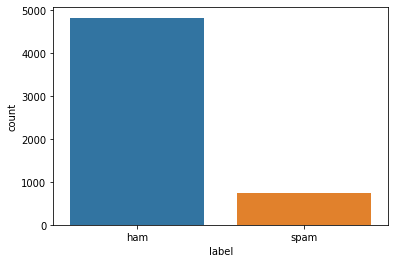

In [5]:
sns.countplot(df["label"])

In [6]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [7]:
encoded_label = {"ham" : 0, "spam" : 1}
df.label.replace("spam", encoded_label["spam"], inplace=True)
df.label.replace("ham", encoded_label["ham"], inplace=True)

In [8]:
sample = pd.concat([df[df["label"] == encoded_label["spam"]], df[df["label"] == encoded_label["ham"]][:747]])
sample.head()

,label,text
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
5,1,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
8,1,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,1,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
11,1,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info"


c:\users\deepblue\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

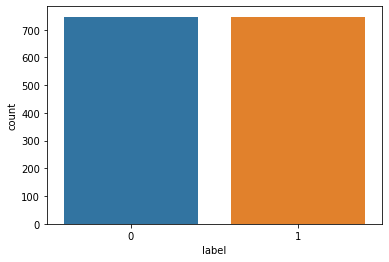

In [9]:
sns.countplot(sample["label"])

In [10]:
sample.text = sample.text.str.lower()
sample.text = sample.text.str.replace('[^\w\s]',' ')
sample.text = sample.text.str.replace(" n ", "and")
sample.text = sample.text.str.replace(" u ", "you")
sample.text = sample.text.str.replace(" r ", "are")
sample.head()

C:\Users\Deepblue\AppData\Local\Temp\ipykernel_22096\231835530.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  sample.text = sample.text.str.replace('[^\w\s]',' ')


,label,text
2,1,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry question std txt rate t c s apply 08452810075over18 s
5,1,freemsg hey there darling it s been 3 week s now and no word back i d like some fun you up for it still tb ok xxx std chgs to send 1 50 to rcv
8,1,winner as a valued network customer you have been selected to receivea 900 prize reward to claim call 09061701461 claim code kl341 valid 12 hours only
9,1,had your mobile 11 months or more your entitled to update to the latest colour mobiles with camera for free call the mobile update co free on 08002986030
11,1,six chances to win cash from 100 to 20 000 pounds txt csh11 and send to 87575 cost 150p day 6days 16 tsandcs apply reply hl 4 info


### Split the dataset into training and validation

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(sample.text, sample.label, test_size = 0.25, shuffle = True, random_state = 42)
print(f"X_train size: {X_train.shape}")
print(f"X_test size: {X_val.shape}")
print(f"y_train size: {y_train.shape}")
print(f"y_test size: {y_val.shape}")

X_train size: (1120,)
X_test size: (374,)
y_train size: (1120,)
y_test size: (374,)


In [12]:
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

### Preprocessing

In [13]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

In [14]:
def preprocess(text_input):
    preprocessed_text = bert_preprocess(text_input)
    embeddings = bert_encoder(preprocessed_text)
    return embeddings['pooled_output']

### Dataset pipeline

In [15]:
training_pipeline = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_pipeline = training_pipeline.batch(32)

### Model

In [16]:
input_ = tf.keras.layers.Input(shape=(512,), name = "input_layer", dtype=tf.float32)
x = tf.keras.layers.Dropout(0.25, name = "dropout")(input_)
x = tf.keras.layers.Dense(1, name = "output")(x)
x = tf.keras.layers.Activation("sigmoid")(x)
model = tf.keras.Model(inputs = input_, outputs = x, name = "classifier")
model.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 512)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 513       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [17]:
binary_loss = tf.keras.losses.BinaryCrossentropy()
optim = tf.keras.optimizers.Adam()

In [18]:
def train_step(x, y):
    with tf.GradientTape() as tape:
        x = preprocess(x)
        pred = model(x)
        loss = binary_loss(pred, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optim.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [19]:
epochs = 10
for epoch in range(epochs):
    losses = []
    # train model for an epoch
    for batch_count, (train_x, train_y) in enumerate(training_pipeline):
        loss = train_step(train_x, train_y)
        losses.append(loss.numpy())
    # validate model's performace
    val_pred = model.predict(preprocess(X_val))
    val_pred = val_pred.reshape(val_pred.shape[0])
    val_loss = binary_loss(val_pred, y_val)
    print(f"Epoch: {epoch + 1} Training loss: {np.mean(losses)} Validation loss: {val_loss.numpy()} Validation accuracy: {accuracy_score((val_pred.reshape(val_pred.shape[0]) > 0.5).astype(np.int8), y_val)}")

Epoch: 1 Training loss: 6.3946146965026855 Validation loss: 5.102138042449951 Validation accuracy: 0.7887700534759359
Epoch: 2 Training loss: 3.8952574729919434 Validation loss: 3.4134628772735596 Validation accuracy: 0.8796791443850267
Epoch: 3 Training loss: 2.739103078842163 Validation loss: 2.6616876125335693 Validation accuracy: 0.8983957219251337
Epoch: 4 Training loss: 2.2155067920684814 Validation loss: 2.25187349319458 Validation accuracy: 0.9197860962566845
Epoch: 5 Training loss: 1.9212367534637451 Validation loss: 1.993382215499878 Validation accuracy: 0.93048128342246
Epoch: 6 Training loss: 1.728792428970337 Validation loss: 1.8118561506271362 Validation accuracy: 0.9358288770053476
Epoch: 7 Training loss: 1.590758204460144 Validation loss: 1.6753336191177368 Validation accuracy: 0.9385026737967914
Epoch: 8 Training loss: 1.485761284828186 Validation loss: 1.56780207157135 Validation accuracy: 0.9385026737967914
Epoch: 9 Training loss: 1.4024028778076172 Validation loss: 

In [20]:
if not os.path.exists("assets/model"):
    os.mkdir("assets/model")
model.save("assets/model")

INFO:tensorflow:Assets written to: assets/model\assets


INFO:tensorflow:Assets written to: assets/model\assets
